In [ ]:
BASE_DIR = '/content/drive/MyDrive/rooftop_detection/'
DATA_DIR = f'{BASE_DIR}malaysia_kuala_lumpur_dataset_final/'
print(DATA_DIR)

/content/drive/MyDrive/rooftop_detection/malaysia_kuala_lumpur_dataset_final/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import library**

In [ ]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
from torch.autograd import Variable

from PIL import Image
import numpy as np
import glob
import os
import albumentations
from albumentations.pytorch import ToTensor
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda:0")

**Analyze dataset**

In [ ]:
class RooftopDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_file = sorted(glob.glob(os.path.join(image_dir, '*.jpg')))
        self.mask_file = sorted(glob.glob(os.path.join(mask_dir, '*.jpg')))
        print(len(self.image_file))
        print(len(self.mask_file))

    def __len__(self):
        return len(self.image_file)

    def __getitem__(self, index):
        image = np.array(Image.open(self.image_file[index]).convert("RGB"))
        mask = np.array(Image.open(self.mask_file[index]).convert("L"), dtype=np.float32)
        mask[mask > 0.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations['image']
            mask = augmentations['mask']

        return image, mask


**Load dataset**

In [ ]:
train_image_folder = f'{DATA_DIR}train/images'
train_mask_folder = f'{DATA_DIR}train/labels'

val_image_folder = f'{DATA_DIR}val/images'
val_mask_folder = f'{DATA_DIR}val/labels'

test_image_folder = f'{DATA_DIR}test/images'
test_mask_folder = f'{DATA_DIR}test/labels'

transform_train = albumentations.Compose([
    albumentations.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
    albumentations.Rotate(limit=35, p=1.0),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.1),
    albumentations.pytorch.ToTensor()
])

transform = albumentations.Compose([
    albumentations.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
    albumentations.pytorch.ToTensor()
])

train_set = RooftopDataset(train_image_folder, train_mask_folder, transform)
val_set = RooftopDataset(val_image_folder, val_mask_folder, transform)
test_set = RooftopDataset(test_image_folder, test_mask_folder, transform)

train_loader = DataLoader(train_set, batch_size=2, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True, num_workers=2)

print(train_set[0][0].size(), train_set[0][1].size())
print(len(train_loader), len(val_loader))

647
647
70
70
70
70
torch.Size([3, 512, 512]) torch.Size([1, 512, 512])
324 70


**Preview dataset**

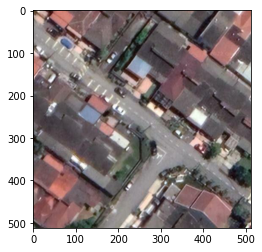

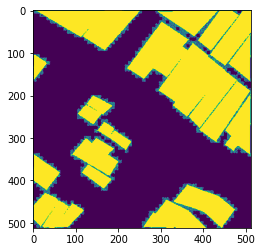

In [ ]:
img, label = train_set[0]
img = img.swapaxes(0,1)
img = img.swapaxes(1,2)
plt.imshow(img)
plt.show()
label = label.swapaxes(0,1)
label = label.swapaxes(1,2)
plt.imshow(label[:,:,0])
plt.show()


**Build UNET**

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1,stride=1,padding=0)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

**Build DABENET**

In [ ]:
class Recurrent_Block(nn.Module):
    def __init__(self, out_channels):
        super(Recurrent_Block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
		    nn.BatchNorm2d(out_channels),
		    nn.ReLU(inplace=True)
        )

    def forward(self,x):
        out = self.conv(x)
        for _ in range(2):
            out = self.conv(x + out)
        return out

class SERRCNN_Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SERRCNN_Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        self.rrcnn = nn.Sequential(
            Recurrent_Block(out_channels),
            Recurrent_Block(out_channels)
        )
        self.squeeze_and_excitation = torchvision.ops.SqueezeExcitation(out_channels, out_channels // 16)

    def forward(self, x):
        x = self.conv(x)
        out = self.rrcnn(x)
        out = self.squeeze_and_excitation(out)
        out = out + x
        return out

class Attention_Gate(nn.Module):
    def __init__(self,in_channels_g, in_channels_l, out_channels):
        super(Attention_Gate,self).__init__()
        self.conv_g = nn.Sequential(
            nn.Conv2d(in_channels_g, out_channels, kernel_size=1,stride=1,padding=0),
            nn.BatchNorm2d(out_channels)
        )
        self.conv_x = nn.Sequential(
            nn.Conv2d(in_channels_l, out_channels, kernel_size=1,stride=1,padding=0),
            nn.BatchNorm2d(out_channels)
        )

        self.relu = nn.ReLU(inplace=True)
        self.psi = nn.Sequential(
            nn.Conv2d(out_channels, 1, kernel_size=1,stride=1,padding=0),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
    def forward(self, g, x):
        g_out = self.conv_g(g)
        x_out = self.conv_x(x)
        psi = self.relu(g_out + x_out)
        psi = self.psi(psi)
        return x * psi

class DABE_NET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(DABE_NET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.attentions = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
  
        for feature in features:
            self.downs.append(SERRCNN_Block(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(SERRCNN_Block(feature*2, feature))
            self.attentions.append(Attention_Gate(feature, feature, feature//2))

        self.bottleneck = SERRCNN_Block(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1,stride=1,padding=0)
    
    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            skip_connection = self.attentions[idx//2](x, skip_connection)
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

**Lovasz Hinge Loss**

In [ ]:
def lovasz_grad(gt_sorted):
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1.0 - gt_sorted).float().cumsum(0)
    jaccard = 1.0 - intersection / union
    if p > 1:
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

def lovasz_hinge(logits, labels):
    loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels))
    return loss

def lovasz_hinge_flat(logits, labels):
    signs = 2.0 * labels.float() - 1.0
    errors = 1.0 - logits * Variable(signs)
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss

def flatten_binary_scores(scores, labels, ignore=None):
    scores = scores.contiguous().view(-1)
    labels = labels.contiguous().view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels

def symmetric_lovasz(outputs, targets):
    return (lovasz_hinge(outputs, targets) + lovasz_hinge(-outputs, 1 - targets)) / 2

class LovaszLossHinge(nn.Module):
    def __init__(self):
        super(LovaszLossHinge, self).__init__()

    def forward(self, input, target):
        loss = lovasz_hinge(input, target)
        return loss

**Measure Unit**

In [ ]:
import math
def iou(pred, target):
    if np.all(target == 0):
        target = 1 - target
        pred = 1 - pred
    intersection = np.logical_and(pred, target)
    union = np.logical_or(pred, target)
    result = np.sum(intersection)/np.sum(union)
    if math.isnan(result): result = 0
    return result

def accuracy(pred, target):
    return np.mean(pred==target)
  
def recall(pred, target):
    TP = np.sum(np.logical_and(pred == 1, target == 1))
    FN = np.sum(np.logical_and(pred == 0, target == 1))
    if (TP + FN) == 0: return 0
    else: return TP/(TP + FN)

def precision(pred, target):
    TP = np.sum(np.logical_and(pred == 1, target == 1))
    FP = np.sum(np.logical_and(pred == 1, target == 0))
    if (TP + FP) == 0: return 0
    else: return TP/(TP + FP)

def f1_score(pred, target):
    TP = np.sum(np.logical_and(pred == 1, target == 1))
    FP = np.sum(np.logical_and(pred == 1, target == 0))
    FN = np.sum(np.logical_and(pred == 0, target == 1))
    if (2*TP + FP + FN) == 0: return 0
    else: return 2*TP/(2*TP + FP + FN)

**Train epoch**

In [ ]:
def train_fn(loader, model, optimizer, loss_fn):
    loop = tqdm(loader)
    model.train()
    running_loss = []
    for batch_idx, (image, mask) in enumerate(loop):
        image = image.to(device)
        mask = mask.float().to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            predict = model(image)
            loss = loss_fn(predict, mask)
            loss.backward()
            running_loss.append(loss.item())
            optimizer.step()
        loop.set_postfix(last_loss=loss.item())
    print()    
    print(f"average_loss={np.mean(running_loss):.4f}", end="")

**Test epoch**

In [ ]:
def test_fn(loader, model, device):
    with torch.no_grad():
        running_iou = []
        running_accuracy = []
        running_recall = []
        running_precision = []
        running_f1_score = []
        model.eval()
        for batch_idx, (images, labels) in enumerate(loader):
            images = images.to(device)
            labels = labels.to(device)

            for i in range(images.shape[0]):
                prediction = torch.sigmoid(model(torch.unsqueeze(images[i], 0)))
                preds = (prediction > 0.5).float().detach().cpu().numpy()
                mask = labels[i].detach().cpu().numpy()
                running_iou.append(iou(preds, mask))
                running_accuracy.append(accuracy(preds, mask))
                running_recall.append(recall(preds, mask))
                running_precision.append(precision(preds, mask))
                running_f1_score.append(f1_score(preds, mask))

    print(f"precision= {np.mean(running_precision):.4f}, recall={np.mean(running_recall):.4f}, "
          f"f1_score={np.mean(running_f1_score):.4f}, accuracy={np.mean(running_accuracy):.4f}, "
          f"iou={np.mean(running_iou):.4f}")
    return (np.mean(running_iou), np.mean(running_accuracy))
    

**Train Baseline model (UNET)**

In [ ]:
model_baseline = UNET(in_channels=3, out_channels=1).to(device)
loss_fn_baseline = symmetric_lovasz
optimizer = optim.Adam(params=model_baseline.parameters(), lr=0.0001)

best_iou_baseline = 0

for epoch in range(10):
    print('Epoch', epoch)   
    train_fn(train_loader, model_baseline, optimizer, loss_fn_baseline)
    out_iou, out_acc = test_fn(val_loader, model_baseline, device)
    best_iou_baseline = max(best_iou_baseline, out_iou)

print(f"best_iou={best_iou_baseline:.4f}")   

Epoch 0


100%|██████████| 324/324 [01:10<00:00,  4.57it/s, last_loss=0.623]


average_loss=0.6535

precision= 0.6481, recall=0.7060, f1_score=0.6554, accuracy=0.8487, iou=0.5482
Epoch 1


100%|██████████| 324/324 [01:11<00:00,  4.55it/s, last_loss=0.536]


average_loss=0.5599

precision= 0.6244, recall=0.7964, f1_score=0.6778, accuracy=0.8311, iou=0.5593
Epoch 2


100%|██████████| 324/324 [01:11<00:00,  4.54it/s, last_loss=2.52]


average_loss=0.5398

precision= 0.5952, recall=0.8536, f1_score=0.6735, accuracy=0.8013, iou=0.5522
Epoch 3


100%|██████████| 324/324 [01:11<00:00,  4.55it/s, last_loss=0.258]


average_loss=0.5302

precision= 0.7129, recall=0.8329, f1_score=0.7529, accuracy=0.8784, iou=0.6474
Epoch 4


100%|██████████| 324/324 [01:11<00:00,  4.55it/s, last_loss=2.35]


average_loss=0.5091

precision= 0.6671, recall=0.8557, f1_score=0.7290, accuracy=0.8579, iou=0.6217
Epoch 5


100%|██████████| 324/324 [01:11<00:00,  4.56it/s, last_loss=0.446]


average_loss=0.5250

precision= 0.7830, recall=0.6926, f1_score=0.7100, accuracy=0.8874, iou=0.6052
Epoch 6


100%|██████████| 324/324 [01:11<00:00,  4.56it/s, last_loss=0.703]


average_loss=0.4885

precision= 0.7221, recall=0.7618, f1_score=0.7206, accuracy=0.8772, iou=0.6162
Epoch 7


100%|██████████| 324/324 [01:11<00:00,  4.56it/s, last_loss=0.41]


average_loss=0.4882

precision= 0.7044, recall=0.8168, f1_score=0.7371, accuracy=0.8736, iou=0.6312
Epoch 8


100%|██████████| 324/324 [01:11<00:00,  4.55it/s, last_loss=0.466]


average_loss=0.4682

precision= 0.6963, recall=0.8311, f1_score=0.7424, accuracy=0.8754, iou=0.6359
Epoch 9


100%|██████████| 324/324 [01:11<00:00,  4.55it/s, last_loss=0.21]


average_loss=0.4647

precision= 0.6161, recall=0.8684, f1_score=0.6962, accuracy=0.8265, iou=0.5787
best_iou=0.6474


**Train model**

In [ ]:
model = DABE_NET(in_channels=3, out_channels=1).to(device)
loss_fn = symmetric_lovasz
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

best_iou = 0

for epoch in range(10):
    print('Epoch', epoch)   
    train_fn(train_loader, model, optimizer, loss_fn)
    out_iou, out_acc = test_fn(val_loader, model, device)
    if out_iou > best_iou:
        best_iou = out_iou
        torch.save(model, BASE_DIR + 'out_model.pt')

print(f"best_iou={best_iou:.4f}")

Epoch 0


100%|██████████| 324/324 [03:34<00:00,  1.51it/s, last_loss=0.45]


average_loss=0.6475

precision= 0.5512, recall=0.8098, f1_score=0.6275, accuracy=0.7732, iou=0.5031
Epoch 1


100%|██████████| 324/324 [03:33<00:00,  1.52it/s, last_loss=0.837]


average_loss=0.5592

precision= 0.5186, recall=0.8975, f1_score=0.6319, accuracy=0.7601, iou=0.5047
Epoch 2


100%|██████████| 324/324 [03:33<00:00,  1.51it/s, last_loss=0.558]


average_loss=0.5331

precision= 0.6073, recall=0.7782, f1_score=0.6549, accuracy=0.8242, iou=0.5409
Epoch 3


100%|██████████| 324/324 [03:33<00:00,  1.52it/s, last_loss=0.729]


average_loss=0.5288

precision= 0.6152, recall=0.7593, f1_score=0.6549, accuracy=0.8301, iou=0.5372
Epoch 4


100%|██████████| 324/324 [03:33<00:00,  1.52it/s, last_loss=0.855]


average_loss=0.5356

precision= 0.5578, recall=0.7758, f1_score=0.6212, accuracy=0.7864, iou=0.5005
Epoch 5


100%|██████████| 324/324 [03:33<00:00,  1.52it/s, last_loss=0.432]


average_loss=0.5121

precision= 0.5406, recall=0.7720, f1_score=0.6133, accuracy=0.7879, iou=0.4961
Epoch 6


100%|██████████| 324/324 [03:33<00:00,  1.51it/s, last_loss=0.284]


average_loss=0.4923

precision= 0.6308, recall=0.8127, f1_score=0.6913, accuracy=0.8516, iou=0.5805
Epoch 7


100%|██████████| 324/324 [03:33<00:00,  1.51it/s, last_loss=0.348]


average_loss=0.4651

precision= 0.6849, recall=0.8060, f1_score=0.7209, accuracy=0.8709, iou=0.6135
Epoch 8


100%|██████████| 324/324 [03:33<00:00,  1.52it/s, last_loss=0.442]


average_loss=0.4474

precision= 0.7519, recall=0.7227, f1_score=0.7179, accuracy=0.8915, iou=0.6217
Epoch 9


100%|██████████| 324/324 [03:33<00:00,  1.52it/s, last_loss=1.02]


average_loss=0.4365

precision= 0.7740, recall=0.6648, f1_score=0.6926, accuracy=0.8770, iou=0.5801
best_iou=0.6217


**Test some picture**

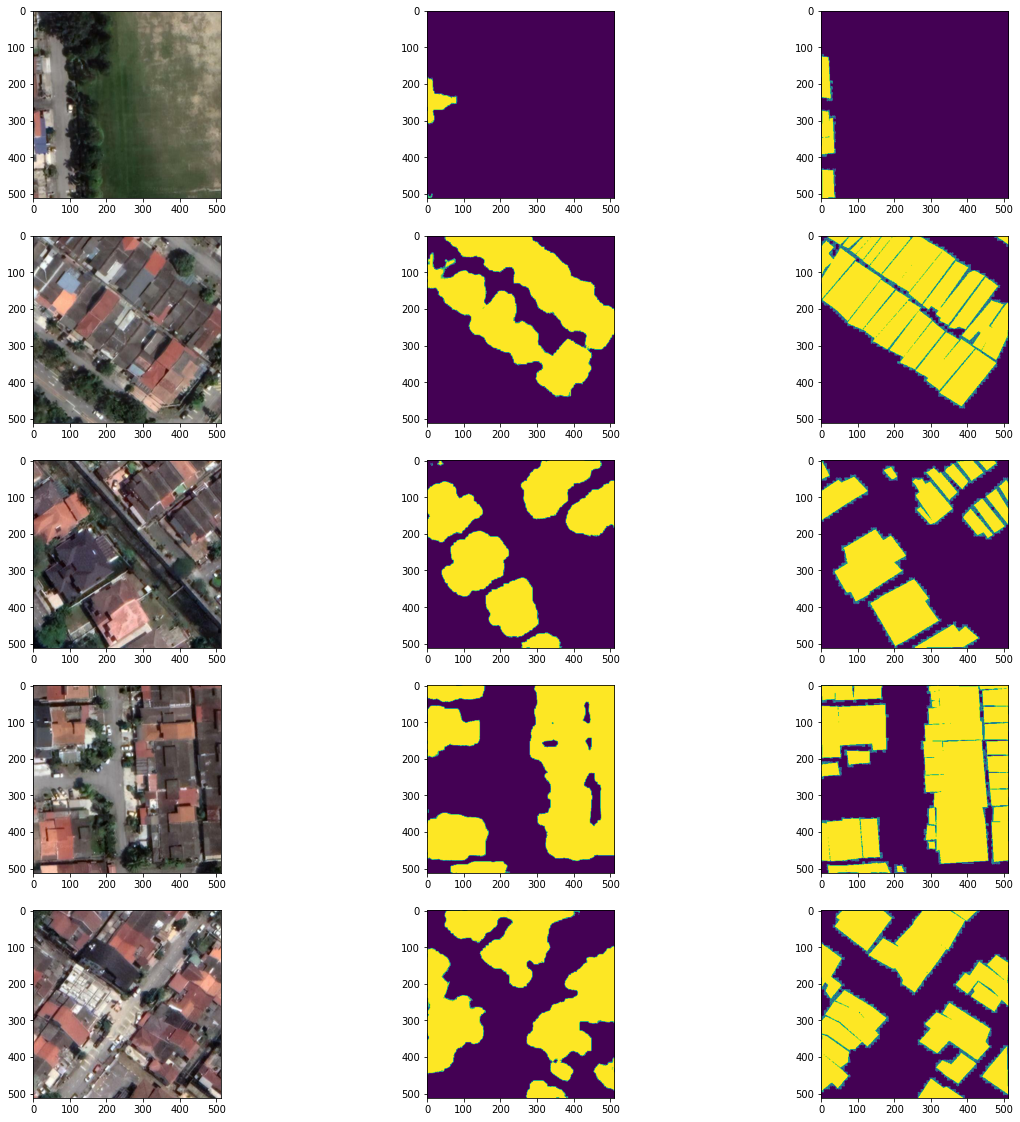

In [ ]:
cnt = 0
rows = 5
columns = 3
fig = plt.figure(figsize=(20, 20))
best_model = torch.load(BASE_DIR + 'out_model.pt')
best_model.eval()

for img, label in test_loader:
    cnt += 1
    
    #print(img[0].size())
    temp = img[0].swapaxes(0,1)
    temp = temp.swapaxes(1,2)
    fig.add_subplot(rows, columns, (cnt-1)*3+1)
    plt.imshow(temp)
   
    
    preds = best_model(img.to(device))
    preds = (preds > 0.5).float()
    temp2 = preds[0].swapaxes(0,1)
    temp2 = temp2.swapaxes(1,2)
    fig.add_subplot(rows, columns, (cnt-1)*3+2)
    plt.imshow(temp2[:,:,0].cpu().detach().numpy())

    temp1 = label[0].swapaxes(0,1)
    temp1 = temp1.swapaxes(1,2)
    fig.add_subplot(rows, columns, (cnt-1)*3+3)
    plt.imshow(temp1[:,:,0])

    if cnt == 5: break
plt.show()    